# Histopathologic Cancer Detection with CNN Models

## Exploratory Data Analysis

Cancerous cells have at least one tumour cells in the center 32x32 region.

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pylab as plt
import seaborn as sns

from tifffile import imread

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

import os
#!pip install visualkeras
#import visualkeras
from skimage import draw

In [2]:
#Loading training directory
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_df['label'] = train_df['label'].astype(str)
train_df['id'] = train_df['id'] + '.tif'
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


0    130908
1     89117
Name: label, dtype: int64

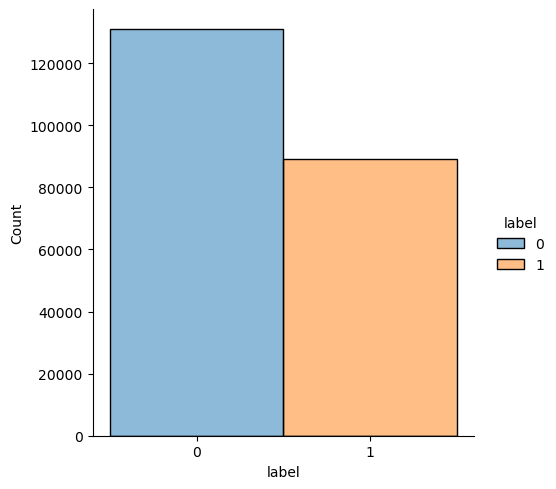

In [4]:
#Checking the labels, how many are negative and how many are positive 
sns.displot(data=train_df, x='label', hue='label')
train_df['label'].value_counts()

In [5]:
#Loading the data with the images 

batch_size, im_size = 256, (96,96)

generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'id', # filenames
    y_col = 'label', # labels
    directory = '/kaggle/input/histopathologic-cancer-detection/train',
    subset = 'training',
    class_mode = 'binary',
    batch_size = batch_size,
    target_size = im_size)

val_data = generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'id', # filenames
    y_col = 'label', # labels
    directory = '/kaggle/input/histopathologic-cancer-detection/train',
    subset = "validation",
    class_mode = 'binary',
    batch_size = batch_size,
    target_size = im_size)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


In [6]:
#PLotting the training graph function with accuracy and loss history 

def plot_hist(hist):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.legend(["Accuracy","Validation Accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.grid()
    plt.subplot(122)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid()
    plt.legend(["Loss","Validation Loss"])
    #plt.suptitle("Model Evaluation")
    plt.tight_layout()
    plt.show()

## VGG16 Backbone

In [9]:
base_model = tf.keras.applications.VGG16(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)


58889256/58889256 [==============================] - 0s 0us/step


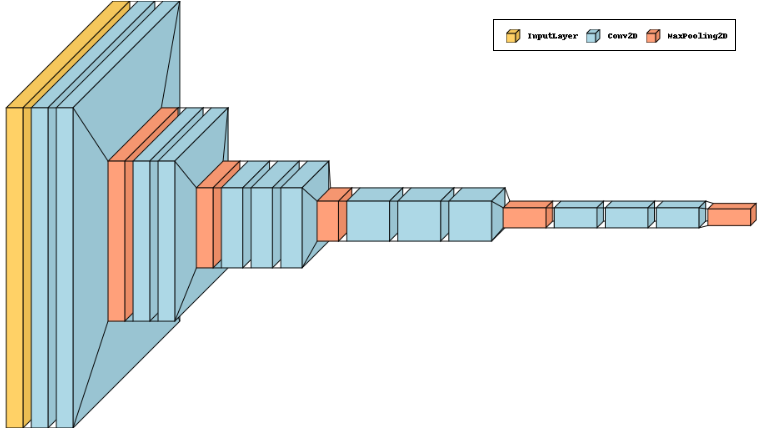

In [ ]:
#Original Model
np.random.seed(1)
tf.random.set_seed(1)
model_vgg16 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='vgg16_backbone')
model_vgg16.summary()

In [21]:
#Model 1
np.random.seed(1)
tf.random.set_seed(1)
model_vgg16 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid') 
], name='vgg16_backbone')
model_vgg16.summary()

Model: "vgg16_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 batch_normalization_9 (Batc  (None, 4608)             18432     
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 16)                73744     
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 8)                 136       
                                                    

In [23]:
#Model 2
np.random.seed(1)
tf.random.set_seed(1)
model_vgg16 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    BatchNormalization()
], name='vgg16_backbone')
model_vgg16.summary()

Model: "vgg16_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 batch_normalization_15 (Bat  (None, 4608)             18432     
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 16)                73744     
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 batch_normalization_16 (Bat  (None, 16)               64        
 chNormalization)                                   

## Training the model


In [24]:
#Compiling code and declaring optimizer 
base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.001)
#opt = tf.keras.optimizers.SGD(0.001)
model_vgg16.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [25]:
model_vgg16.summary()

Model: "vgg16_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 batch_normalization_15 (Bat  (None, 4608)             18432     
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 16)                73744     
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 batch_normalization_16 (Bat  (None, 16)               64        
 chNormalization)                                   

In [26]:
%%time 
# Training 
hist = model_vgg16.fit(train_data, epochs = 9, validation_data = val_data, verbose=1)

Epoch 1/9
645/645 [==============================] - 366s 557ms/step - loss: 1.0190 - accuracy: 0.6596 - auc_2: 0.7115 - val_loss: 1.0679 - val_accuracy: 0.4230 - val_auc_2: 0.8041
Epoch 2/9
645/645 [==============================] - 355s 550ms/step - loss: 0.8822 - accuracy: 0.6135 - auc_2: 0.6564 - val_loss: 6.2497 - val_accuracy: 0.5948 - val_auc_2: 0.4994
Epoch 3/9
645/645 [==============================] - 345s 534ms/step - loss: 0.6525 - accuracy: 0.6053 - auc_2: 0.6743 - val_loss: 0.7261 - val_accuracy: 0.4045 - val_auc_2: 0.5040
Epoch 4/9
645/645 [==============================] - 344s 533ms/step - loss: 0.6176 - accuracy: 0.6369 - auc_2: 0.6959 - val_loss: 1.0598 - val_accuracy: 0.4652 - val_auc_2: 0.5576
Epoch 5/9
645/645 [==============================] - 350s 543ms/step - loss: 0.6052 - accuracy: 0.6622 - auc_2: 0.7142 - val_loss: 6.2388 - val_accuracy: 0.5955 - val_auc_2: 0.5000
Epoch 6/9
645/645 [==============================] - 341s 529ms/step - loss: 0.5946 - accuracy:

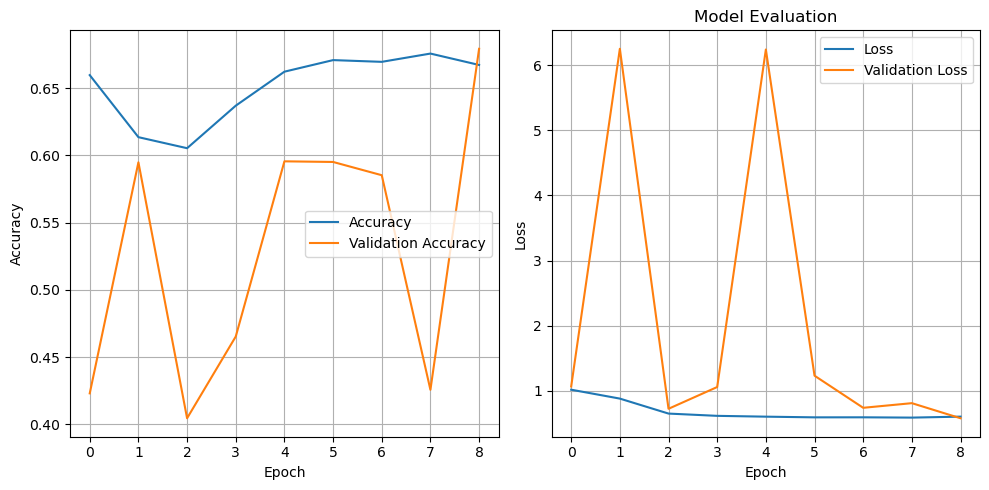

In [29]:
#Plotting Accuracies during training
plot_hist(hist)

## VGG19 Backbone

In [30]:
base_model = tf.keras.applications.VGG19(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

80134624/80134624 [==============================] - 1s 0us/step


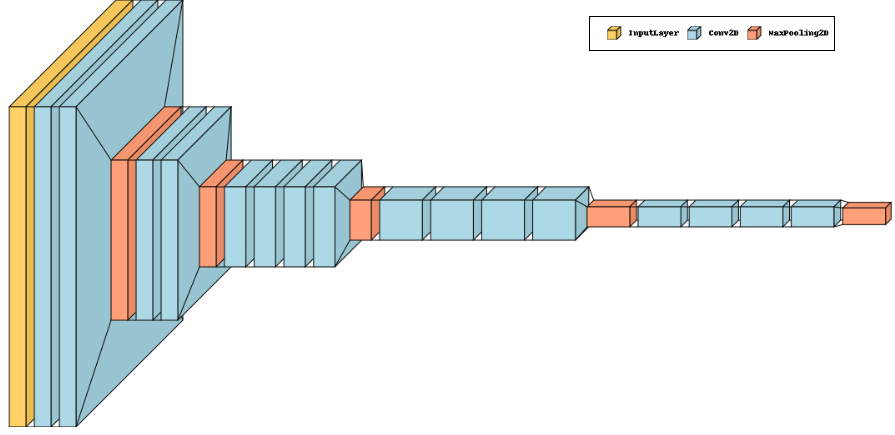

In [37]:
np.random.seed(1)
tf.random.set_seed(1)
#Model 2
model_vgg19 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    BatchNormalization()
], name='vgg19_backbone')

model_vgg19.summary()

Model: "vgg19_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 4608)              0         
                                                                 
 batch_normalization_21 (Bat  (None, 4608)             18432     
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 16)                73744     
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 batch_normalization_22 (Bat  (None, 16)               64        
 chNormalization)                                   

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Original Model 
model_vgg19 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='vgg19_backbone')

model_vgg19.summary()

In [ ]:
#Model 1
np.random.seed(1)
tf.random.set_seed(1)
model_vgg19 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid') 
], name='vgg19_backbone')
model_vgg19.summary()

In [40]:
#Compiling model and declaring optimizer
opt = tf.keras.optimizers.Adam(0.001)
#opt = tf.keras.optimizers.SGD(0.001)
base_model.trainable = True
model_vgg19.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [41]:
%%time 
# Training
hist = model_vgg19.fit(train_data, epochs = 7, validation_data = val_data, verbose=1)

Epoch 1/7
645/645 [==============================] - 362s 550ms/step - loss: 2.4764 - accuracy: 0.5743 - auc_6: 0.5931 - val_loss: 0.9857 - val_accuracy: 0.4053 - val_auc_6: 0.5647
Epoch 2/7
645/645 [==============================] - 346s 537ms/step - loss: 0.9755 - accuracy: 0.7071 - auc_6: 0.7683 - val_loss: 0.7395 - val_accuracy: 0.5403 - val_auc_6: 0.8252
Epoch 3/7
645/645 [==============================] - 345s 535ms/step - loss: 1.0299 - accuracy: 0.6702 - auc_6: 0.7272 - val_loss: 0.8098 - val_accuracy: 0.6459 - val_auc_6: 0.7517
Epoch 4/7
645/645 [==============================] - 352s 546ms/step - loss: 0.9536 - accuracy: 0.6211 - auc_6: 0.6719 - val_loss: 6.2055 - val_accuracy: 0.5885 - val_auc_6: 0.4810
Epoch 5/7
645/645 [==============================] - 356s 551ms/step - loss: 0.9131 - accuracy: 0.6166 - auc_6: 0.6616 - val_loss: 0.6452 - val_accuracy: 0.6220 - val_auc_6: 0.6845
Epoch 6/7
645/645 [==============================] - 357s 553ms/step - loss: 0.8022 - accuracy:

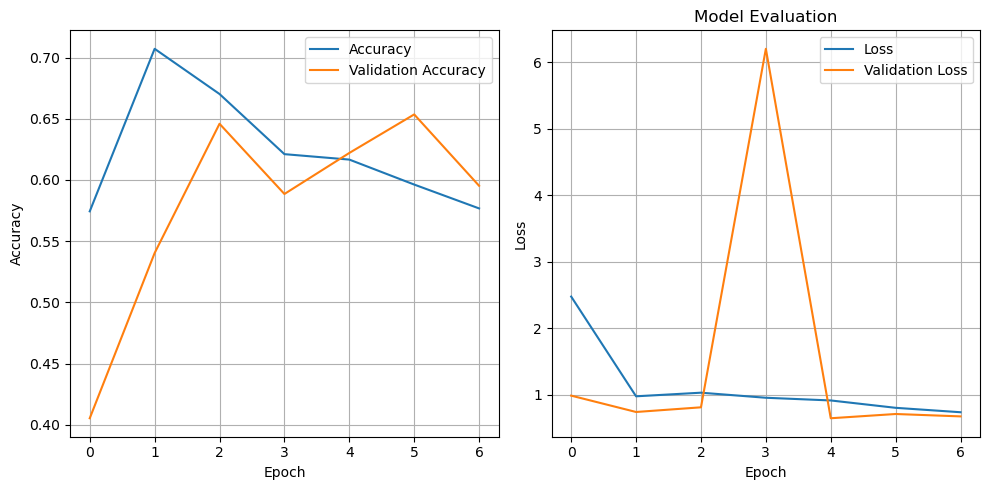

In [42]:
#Plotting Accuracies during training
plot_hist(hist)

## ResNet50 Backbone

In [45]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

94765736/94765736 [==============================] - 1s 0us/step


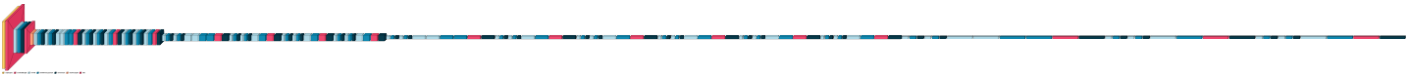

In [31]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 1
model_resnet50 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], 'resnet50_backbone')

model_resnet50.summary()

Model: "resnet50_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 batch_normalization_9 (Batc  (None, 18432)            73728     
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 16)                294928    
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                170       
                                                 

In [53]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 2
model_resnet50 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    #BatchNormalization()
], 'resnet50_backbone')

model_resnet50.summary()

Model: "resnet50_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_9 (Flatten)         (None, 18432)             0         
                                                                 
 batch_normalization_27 (Bat  (None, 18432)            73728     
 chNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 16)                294928    
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 batch_normalization_28 (Bat  (None, 16)               64        
 chNormalization)                                

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Original Model 
model_resnet50 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='resnet50_backbone')

model_resnet50.summary()

## Training 

In [55]:
#Compiling model and declaring optimizer 
base_model.trainable = True
#opt = tf.keras.optimizers.SGD(0.0003)
opt = tf.keras.optimizers.Adam(0.001)
model_resnet50.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [56]:
%%time 
#remnoved batch normalization
#Training
hist = model_resnet50.fit(train_data, validation_data=val_data, epochs=8, verbose=1)

Epoch 1/8
645/645 [==============================] - 395s 561ms/step - loss: 0.3787 - accuracy: 0.8293 - auc_10: 0.9065 - val_loss: 0.9528 - val_accuracy: 0.7675 - val_auc_10: 0.8162
Epoch 2/8
645/645 [==============================] - 348s 539ms/step - loss: 0.2159 - accuracy: 0.9180 - auc_10: 0.9689 - val_loss: 0.3430 - val_accuracy: 0.8789 - val_auc_10: 0.9460
Epoch 3/8
645/645 [==============================] - 346s 537ms/step - loss: 0.1780 - accuracy: 0.9346 - auc_10: 0.9785 - val_loss: 0.4225 - val_accuracy: 0.8649 - val_auc_10: 0.9224
Epoch 4/8
645/645 [==============================] - 394s 611ms/step - loss: 0.1535 - accuracy: 0.9443 - auc_10: 0.9837 - val_loss: 0.4166 - val_accuracy: 0.8554 - val_auc_10: 0.9284
Epoch 5/8
645/645 [==============================] - 388s 602ms/step - loss: 0.1389 - accuracy: 0.9500 - auc_10: 0.9865 - val_loss: 1.1030 - val_accuracy: 0.7388 - val_auc_10: 0.8761
Epoch 6/8
645/645 [==============================] - 348s 539ms/step - loss: 0.1246 -

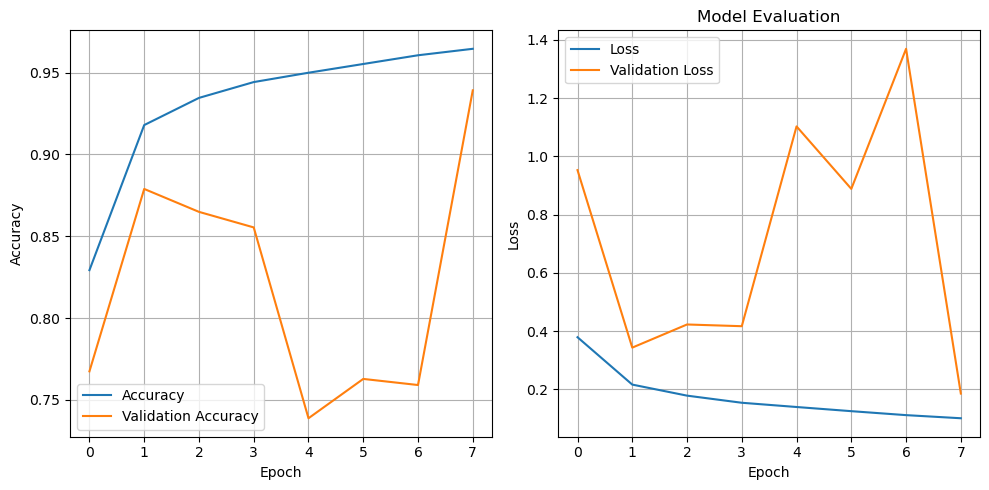

In [57]:
#Plotting Accuracies during training
plot_hist(hist)

## Resnet 101

In [33]:
base_model = tf.keras.applications.ResNet101(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

In [12]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 1
model_resnet101 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], 'resnet101_backbone')

model_resnet101.summary()

Model: "resnet101_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 3, 3, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 batch_normalization (BatchN  (None, 18432)            73728     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 16)                294928    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                

In [35]:
# Compiling the model and declaring the optimizer 
base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.001)
#opt = tf.keras.optimizers.SGD(0.001)
model_resnet101.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [34]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 2
model_resnet101 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    #BatchNormalization()
], 'resnet101_backbone')

model_resnet101.summary()

NameError: name 's' is not defined

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Original Model 
model_resnet101 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='resnet101_backbone')

model_resnet101.summary()

In [36]:
%%time 
# Training
hist = model_resnet101.fit(train_data, validation_data=val_data, epochs=7, verbose=1)

Epoch 1/7
645/645 [==============================] - 683s 955ms/step - loss: 0.2150 - accuracy: 0.9200 - auc_7: 0.9687 - val_loss: 0.2846 - val_accuracy: 0.9171 - val_auc_7: 0.9619
Epoch 2/7
645/645 [==============================] - 502s 779ms/step - loss: 0.1498 - accuracy: 0.9469 - auc_7: 0.9842 - val_loss: 0.2581 - val_accuracy: 0.9068 - val_auc_7: 0.9698
Epoch 3/7
645/645 [==============================] - 483s 748ms/step - loss: 0.1240 - accuracy: 0.9562 - auc_7: 0.9888 - val_loss: 0.4190 - val_accuracy: 0.8605 - val_auc_7: 0.9177
Epoch 4/7
645/645 [==============================] - 422s 654ms/step - loss: 0.1053 - accuracy: 0.9634 - auc_7: 0.9917 - val_loss: 1.5096 - val_accuracy: 0.7241 - val_auc_7: 0.7755
Epoch 5/7
645/645 [==============================] - 399s 619ms/step - loss: 0.0882 - accuracy: 0.9699 - auc_7: 0.9940 - val_loss: 0.6421 - val_accuracy: 0.8510 - val_auc_7: 0.9175
Epoch 6/7
645/645 [==============================] - 402s 622ms/step - loss: 0.0742 - accuracy:

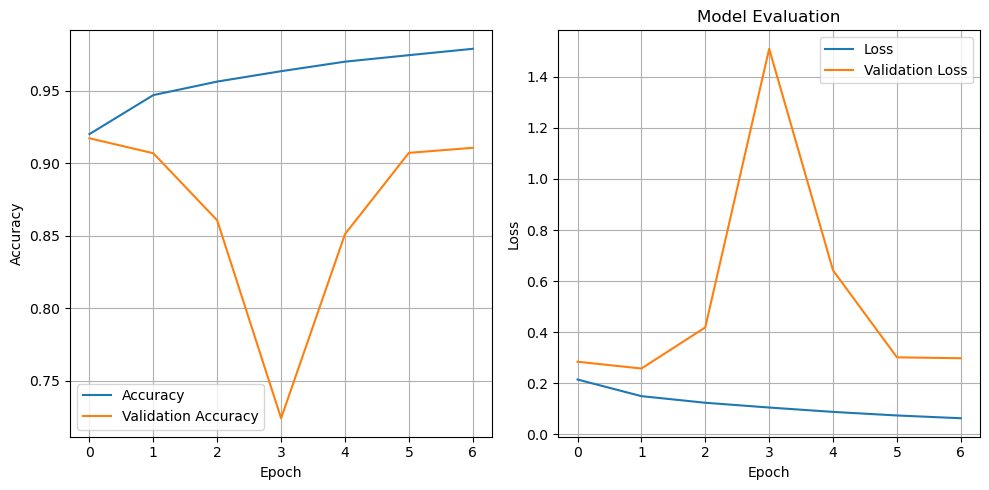

In [40]:
#Plotting Accuracies during training
plot_hist(hist)

## MobileNetV2


In [7]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

9406464/9406464 [==============================] - 0s 0us/step


In [8]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 2
model_mobilenetv2 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    #BatchNormalization()
], 'mobilenetv2_backbone')

model_mobilenetv2.summary()

Model: "mobilenetv2_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 batch_normalization (BatchN  (None, 11520)            46080     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 16)                184336    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 16)      

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Original Model 
model_mobilenetv2 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='mobilenetv2_backbone')

model_mobilenetv2.summary()

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 1
model_mobilenetv2 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], 'mobilnetv2_backbone')

model_mobilenetv2.summary()

In [9]:
#Declaring optimizer and compiling the model 
base_model.trainable = True
opt = tf.keras.optimizers.SGD(0.001)
#opt = tf.keras.optimizers.Adam(0.001)
model_mobilenetv2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

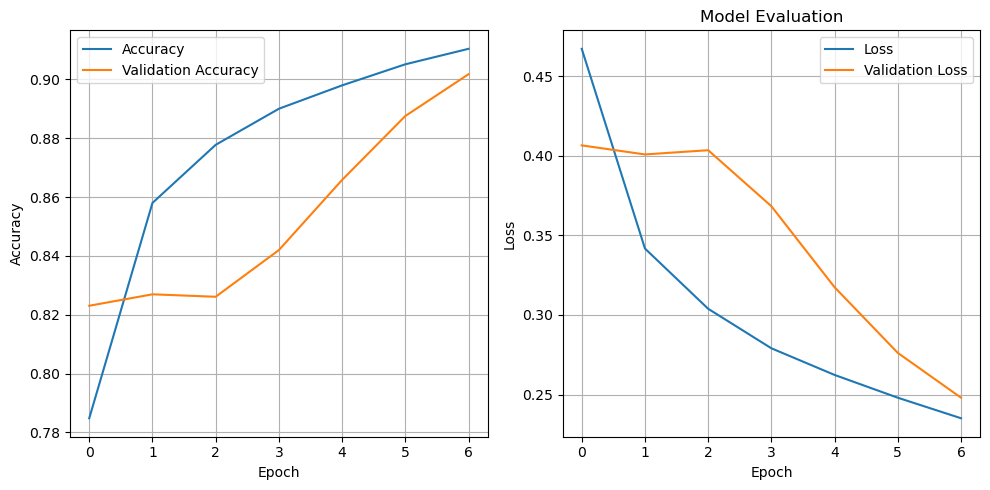

In [16]:
#Plotting Accuracies during training
plot_hist(hist)

In [10]:
# Trainining
hist = model_mobilenetv2.fit(train_data, validation_data=val_data, epochs=7, verbose=1)

Epoch 1/7
645/645 [==============================] - 1468s 2s/step - loss: 0.4673 - accuracy: 0.7848 - auc: 0.8605 - val_loss: 0.4066 - val_accuracy: 0.8231 - val_auc: 0.8885
Epoch 2/7
645/645 [==============================] - 491s 761ms/step - loss: 0.3418 - accuracy: 0.8580 - auc: 0.9241 - val_loss: 0.4009 - val_accuracy: 0.8270 - val_auc: 0.9196
Epoch 3/7
645/645 [==============================] - 323s 500ms/step - loss: 0.3039 - accuracy: 0.8778 - auc: 0.9402 - val_loss: 0.4036 - val_accuracy: 0.8261 - val_auc: 0.9335
Epoch 4/7
645/645 [==============================] - 341s 528ms/step - loss: 0.2791 - accuracy: 0.8900 - auc: 0.9497 - val_loss: 0.3684 - val_accuracy: 0.8420 - val_auc: 0.9454
Epoch 5/7
645/645 [==============================] - 336s 521ms/step - loss: 0.2623 - accuracy: 0.8980 - auc: 0.9555 - val_loss: 0.3174 - val_accuracy: 0.8659 - val_auc: 0.9542
Epoch 6/7
645/645 [==============================] - 319s 495ms/step - loss: 0.2480 - accuracy: 0.9052 - auc: 0.9602 

## MobileNet


In [ ]:
base_model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 1
model_mobilenet = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], 'mobilnet_backbone')

model_mobilenet.summary()

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Original Model 
model_mobilenet = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='mobilenet_backbone')

model_mobilenet.summary()

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

#Model 2
model_mobilenet = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
    #BatchNormalization()
], 'mobilenet_backbone')

model_mobilenet.summary()

In [ ]:
#Declaring optimizer and compiling models 
base_model.trainable = True
opt = tf.keras.optimizers.SGD(0.001)
#opt = tf.keras.optimizers.Adam(0.001)
model_mobilenet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
#Plotting Accuracies during training
plot_hist(hist)

In [ ]:
# Training
hist = model_mobilenet.fit(train_data, validation_data=val_data, epochs=7, verbose=1)